In [1]:
import sys
# This on is a path correcting code, which is used to find the path of QuSim.
sys.path.append('../../..')
import QuSim.DataPlot.plot_lib as pl
import QuSim.Instruments.tools as tools
import QuSim.Instruments.stochastic_gen as sg
import QuSim.System.arb_qubit_system as aqs
import QuSim.Instruments.angle as  ang
from QuSim.Instruments.angle import get_angle

import numpy as np
import matplotlib.pyplot as plt

from tqdm import *
from time import *
from sympy import*
import copy
import pickle
from qutip import*

def var_name2str(variable):
    def nested_var_name2str(value):
        if isinstance(value, list):
            return [nested_var_name2str(item) for item in value]
        else:
            for name in globals():
                if eval(name) == value:
                    return name
            return str(value)
    return nested_var_name2str(variable)

# Print the full output
np.set_printoptions(threshold=sys.maxsize)

# auto reload
%load_ext autoreload
%autoreload 2 

import ipywidgets as widgets
from IPython.display import display
from tkinter import Tk, filedialog
import os

def select_files(b):
    root = Tk()
    root.withdraw()
    root.call('wm', 'attributes', '.', '-topmost', True)
    # Enable multiple file selection and set the initial directory
    filepaths = filedialog.askopenfilenames(initialdir="../../../Data/")
    root.destroy()
    # Extract filenames from the full paths and store them in a list
    filenames = [os.path.basename(filepath) for filepath in filepaths]
    print("Selected files:", filenames)
    b.filenames = filenames  # Store filenames in the button for further use if needed

fileselect = widgets.Button(description="Select Files")
fileselect.on_click(select_files)

# Large detuning

In [3]:
freq_list = [ # GHz
    [0, 10.35],
    [0, 10],
    [0, 10.25],
    [0, 10.15]
]

inter_list = [
    [{
        "v01": 0,
        "v00": 1,
        "v11": -1
    },
    {
        "v01": 0,
        "v00": 1,
        "v11": -1
    }
    ,
    {
        "v01": 0,
        "v00": 1,
        "v11": -1
    },
    {
        "v01": 0,
        "v00": 1,
        "v11": -1
    }],
    [{
        "v01": 1,
        "v00": 0,
        "v11": 0
    },
    {
        "v01": 1,
        "v00": 0,
        "v11": 0
    }
    ,
    {
        "v01": 1,
        "v00": 0,
        "v11": 0
    },
    {
        "v01": 1,
        "v00": 0,
        "v11": 0
    }]
    ,
    [{
        "v01": -1j,
        "v00": 0,
        "v11": 0
    },
    {
        "v01": -1j,
        "v00": 0,
        "v11": 0
    }
    ,
    {
        "v01": -1j,
        "v00": 0,
        "v11": 0
    },
    {
        "v01": -1j,
        "v00": 0,
        "v11": 0
    }]
]

r_dic = {
    "r12": 1e-3,
    "r23": 1e-3,
    "r34": 1e-3
}
r = tools.r2matrix(r_dic, freq_list) # Coupling strength

extra_list=None
## with pulse type XY
driving_list = [
    {
        "W01": 1j   # W01 represents \Omega_{01}, for the qubit with index 0
    },
    {
        "W01": 1j
    },
    {
        "W01": 1j
    },
    {
        "W01": 1j
    }
]

## with pulse type Z
bias_list = [ # Default, Z00 = 0
    {
        "Z11": 1
    },
    {
        "Z11": 1
    },
    {
        "Z11": 1
    },
    {
        "Z11": 1
    }
]

gamma_list = None

# gamma_list = None

_system_arb1 = aqs.arb_qubit_system(freq_list, inter_list, r, extra_list, gamma_list, driving_list, bias_list)

state_0000, E_0000, _= _system_arb1.get_eigenstates_energy((0,0,0,0))

state_0001, E_0001, _= _system_arb1.get_eigenstates_energy((0,0,0,1))
state_0010, E_0010, _= _system_arb1.get_eigenstates_energy((0,0,1,0))
state_0100, E_0100, _= _system_arb1.get_eigenstates_energy((0,1,0,0))
state_1000, E_1000, _= _system_arb1.get_eigenstates_energy((1,0,0,0))

"""subspace"""
state_0101, E_0101, index_0101= _system_arb1.get_eigenstates_energy((0,1,0,1))
state_1001, E_1001, index_1001= _system_arb1.get_eigenstates_energy((1,0,0,1))
state_0110, E_0110, index_0110= _system_arb1.get_eigenstates_energy((0,1,1,0))
state_1010, E_1010, index_1010= _system_arb1.get_eigenstates_energy((1,0,1,0))

"""leakage"""
state_0011, E_0011, index_0011= _system_arb1.get_eigenstates_energy((0,0,1,1))
state_1100, E_1100, index_1100= _system_arb1.get_eigenstates_energy((1,1,0,0))

state_0111, E_0111, _= _system_arb1.get_eigenstates_energy((0,1,1,1))
state_1011, E_1011, _= _system_arb1.get_eigenstates_energy((1,0,1,1))
state_1101, E_1101, _= _system_arb1.get_eigenstates_energy((1,1,0,1))
state_1110, E_1110, _= _system_arb1.get_eigenstates_energy((1,1,1,0))

state_1111, E_1111, _= _system_arb1.get_eigenstates_energy((1,1,1,1))

state_ud = Qobj(np.array([0,0,1,0]), dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket)
state_du = Qobj(np.array([0,1,0,0]), dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket)

state_dudu = tensor(state_du,state_du)
state_duud = tensor(state_du,state_ud)
state_uddu = tensor(state_ud,state_du)
state_udud = tensor(state_ud,state_ud)

_system_arb1.H

Quantum object: dims = [[2, 2, 2, 2], [2, 2, 2, 2]], shape = (16, 16), type = oper, isherm = True
Qobj data =
[[1.88495559e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 6.37806141e+01 1.25663706e-02 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.25663706e-02 6.43963662e+01 0.00000000e+00
  1.25663706e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.28183263e+02
  0.00000000e+00 1.25663706e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.

In [10]:
# Construct a decoupled system
def get_single_qubit_phase(t_width):
    r_dic2 = {
        "r12": 0,
        "r23": 0,
        "r34": 0
    }
    r2 = tools.r2matrix(r_dic2, freq_list) # Coupling strength
    extra_list=None
    _system_arb2 = aqs.arb_qubit_system(freq_list, inter_list, r2, extra_list, gamma_list, driving_list, bias_list)
    # t_width = 40; 
    simulation_option2 = {
        "simulation_time": t_width, # ns
        "simulation_step": 10000,
        "initial_state": [state_dudu, state_duud, state_uddu, state_udud]  # Do multiple simulation
    }
    # simulation_option2['simulation_time'] = 154
    pulse_sequence2 = [
        {
            'pulse_index': 1, # [m,n] represents $\Omega_{mn}$
            'type': "INT",
            'pulse_shape': "cosine",
            't_delay': 0, # unit in ns
            't_width': t_width, # unit in ns
            't_plateau':simulation_option2['simulation_time'] - t_width , # unit in ns
            'freq': 0, # unit in GHz; Z pulse does not use it
            'phase': 0, # unit in rad; Z pulse does not use it
            'amplitude': 0, # XY: Rabi freq; Z: biased frequency
            'q_index': [1,2]
        }
    ]
    result_list2, angle_list2 = _system_arb2.system_dynamics_mesolve(simulation_option2, pulse_sequence2)

    q_pmatrix = np.array([[np.exp(-1j*angle_list2[0][0][0]),0,0,0], 
                [0, np.exp(-1j*angle_list2[1][0][0]), 0, 0],
                [0,0, np.exp(-1j*angle_list2[2][0][0]), 0],
                [0,0,0, np.exp(-1j *angle_list2[3][0][0])]])
    # single qubit rotation correcting phase gate during ZZ inter
    q_phase_gate = Qobj(q_pmatrix,
                dims = [[2,2], [2,2]])
    q_phase_gate = q_phase_gate/q_phase_gate.data[0,0]
    return q_phase_gate


In [11]:
j23bias_scan_rng = np.linspace(1e-3, 350e-3, 1000)
t_width_scan_rng = np.linspace(35, 45, 10)
leakage_list = []; angle_cphase=[]; Cphase_melements= []
for tw in tqdm(t_width_scan_rng):
    angle_cphase_dummy = []
    dummy_list = []
    for bisa_amp in tqdm(j23bias_scan_rng, leave=False):

        simulation_option = {
            "simulation_time": tw, # ns
            "simulation_step": 10000,
            "initial_state": [state_dudu, state_duud, state_uddu, state_udud]  # Do multiple simulation
        }
        pulse_sequence = [
        {
            'pulse_index': 0, # [m,n] represents $\Omega_{mn}$
            'type': "INT",
            'pulse_shape': "cosine",
            't_delay': 0, # unit in ns
            't_width': tw, # unit in ns
            't_plateau':0, # unit in ns
            'freq': 0, # unit in GHz; Z pulse does not use it
            'phase': 0, # unit in rad; Z pulse does not use it
            'amplitude': bisa_amp, # XY: Rabi freq; Z: biased frequency
            'q_index': [1,2]
        }]
        result_list, angle_list = _system_arb1.system_dynamics_mesolve(simulation_option, pulse_sequence)
        propa_list = _system_arb1.system_dynamics_propagator(simulation_option, pulse_sequence, do_progress_bar=None)

        lk_dummy = []
        for i in range(len(simulation_option["initial_state"])):
            lk = 1 - np.abs(((state_udud + state_dudu + state_duud + state_uddu ).dag()* result_list[i].states[-1]).data[0,0])
            lk_dummy.append(lk)
        dummy_list.append(np.average(lk_dummy))

        q_phase_gate = get_single_qubit_phase(tw)

        U = propa_list[-1] # get the Unitary 
        # Perform partial trace, tracing out the coupler degree of freedom
        slist = [
            state_dudu, state_duud, state_uddu, state_udud
        ]
        sdlist = [
            state_dudu.dag(), state_duud.dag(), state_uddu.dag(), state_udud.dag()
        ]
        dims = [len(sdlist), len(slist)];   umatrix = []
        for i in range(dims[0]):
            umatrix_row = []
            for j in range(dims[1]):
                umatrix_row.append(sdlist[i] * U * slist[j])
            umatrix.append(umatrix_row)

        Usim = Qobj(np.array(umatrix).reshape(dims[0],dims[1]), dims = [[int(np.sqrt(dims[0])), int(np.sqrt(dims[0]))], [int(np.sqrt(dims[1])), int(np.sqrt(dims[1]))]])
        Usim = Usim/Usim.data[0,0]
        
        Usim_p = Usim * q_phase_gate
        # Phase gate after ZZ inter, correcting single qubit phase
        phi12 = -np.angle(Usim_p.data[1,1])
        phi34 = -np.angle(Usim_p.data[2,2])
        c_pmatrix = np.array([[1,0,0,0], 
                    [0, np.exp(1j*phi12), 0, 0],
                    [0,0, np.exp(1j*phi34), 0],
                    [0,0,0, np.exp(1j *(phi12+phi34))]])
        # correcting phase gate
        c_phase_gate = Qobj(c_pmatrix,
                    dims = [[2,2], [2,2]])
        Uphase = Usim_p * c_phase_gate

        angle_cphase_dummy.append(np.angle(Uphase.data[3,3]))
    angle_cphase.append(angle_cphase_dummy)
    leakage_list.append(dummy_list)
    # Cphase_melements.append([Uphase.data[jj,jj] for jj in range(4)])

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [44:04:19<00:00, 1586.59s/it]  


# Small detuning

In [3]:
freq_list = [ # GHz
    [0, 10.028],
    [0, 10],
    [0, 10.025],
    [0, 10.015]
]

inter_list = [
    [{
        "v01": 0,
        "v00": 1,
        "v11": -1
    },
    {
        "v01": 0,
        "v00": 1,
        "v11": -1
    }
    ,
    {
        "v01": 0,
        "v00": 1,
        "v11": -1
    },
    {
        "v01": 0,
        "v00": 1,
        "v11": -1
    }],
    [{
        "v01": 1,
        "v00": 0,
        "v11": 0
    },
    {
        "v01": 1,
        "v00": 0,
        "v11": 0
    }
    ,
    {
        "v01": 1,
        "v00": 0,
        "v11": 0
    },
    {
        "v01": 1,
        "v00": 0,
        "v11": 0
    }]
    ,
    [{
        "v01": -1j,
        "v00": 0,
        "v11": 0
    },
    {
        "v01": -1j,
        "v00": 0,
        "v11": 0
    }
    ,
    {
        "v01": -1j,
        "v00": 0,
        "v11": 0
    },
    {
        "v01": -1j,
        "v00": 0,
        "v11": 0
    }]
]

r_dic = {
    "r12": 4e-3,
    "r23": 4e-3,
    "r34": 4e-3
}
r = tools.r2matrix(r_dic, freq_list) # Coupling strength

extra_list=None
## with pulse type XY
driving_list = [
    {
        "W01": 1j   # W01 represents \Omega_{01}, for the qubit with index 0
    },
    {
        "W01": 1j
    },
    {
        "W01": 1j
    },
    {
        "W01": 1j
    }
]

## with pulse type Z
bias_list = [ # Default, Z00 = 0
    {
        "Z11": 1
    },
    {
        "Z11": 1
    },
    {
        "Z11": 1
    },
    {
        "Z11": 1
    }
]

gamma_list = None

# gamma_list = None

_system_arb1 = aqs.arb_qubit_system(freq_list, inter_list, r, extra_list, gamma_list, driving_list, bias_list)

state_0000, E_0000, _= _system_arb1.get_eigenstates_energy((0,0,0,0))

state_0001, E_0001, _= _system_arb1.get_eigenstates_energy((0,0,0,1))
state_0010, E_0010, _= _system_arb1.get_eigenstates_energy((0,0,1,0))
state_0100, E_0100, _= _system_arb1.get_eigenstates_energy((0,1,0,0))
state_1000, E_1000, _= _system_arb1.get_eigenstates_energy((1,0,0,0))

"""subspace"""
state_0101, E_0101, index_0101= _system_arb1.get_eigenstates_energy((0,1,0,1))
state_1001, E_1001, index_1001= _system_arb1.get_eigenstates_energy((1,0,0,1))
state_0110, E_0110, index_0110= _system_arb1.get_eigenstates_energy((0,1,1,0))
state_1010, E_1010, index_1010= _system_arb1.get_eigenstates_energy((1,0,1,0))

"""leakage"""
state_0011, E_0011, index_0011= _system_arb1.get_eigenstates_energy((0,0,1,1))
state_1100, E_1100, index_1100= _system_arb1.get_eigenstates_energy((1,1,0,0))

state_0111, E_0111, _= _system_arb1.get_eigenstates_energy((0,1,1,1))
state_1011, E_1011, _= _system_arb1.get_eigenstates_energy((1,0,1,1))
state_1101, E_1101, _= _system_arb1.get_eigenstates_energy((1,1,0,1))
state_1110, E_1110, _= _system_arb1.get_eigenstates_energy((1,1,1,0))

state_1111, E_1111, _= _system_arb1.get_eigenstates_energy((1,1,1,1))

_system_arb1.H

Quantum object: dims = [[2, 2, 2, 2], [2, 2, 2, 2]], shape = (16, 16), type = oper, isherm = True
Qobj data =
[[7.53982237e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 6.29512336e+01 5.02654825e-02 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 5.02654825e-02 6.29638000e+01 0.00000000e+00
  5.02654825e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.25940166e+02
  0.00000000e+00 5.02654825e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.

In [4]:
# Construct a decoupled system
def get_single_qubit_phase(simulation_option):
    r_dic2 = {
        "r12": 0,
        "r23": 0,
        "r34": 0
    }
    r2 = tools.r2matrix(r_dic2, freq_list) # Coupling strength
    extra_list=None
    _system_arb2 = aqs.arb_qubit_system(freq_list, inter_list, r2, extra_list, gamma_list, driving_list, bias_list)


    """subspace"""
    state_0101, E_0101, index_0101= _system_arb1.get_eigenstates_energy((0,1,0,1))
    state_1001, E_1001, index_1001= _system_arb1.get_eigenstates_energy((1,0,0,1))
    state_0110, E_0110, index_0110= _system_arb1.get_eigenstates_energy((0,1,1,0))
    state_1010, E_1010, index_1010= _system_arb1.get_eigenstates_energy((1,0,1,0))
    simulation_option2 = simulation_option
    simulation_option2['initial_state'] = [state_0101, state_0110, state_1001, state_1010]
    t_width = simulation_option2["simulation_time"]
    # simulation_option2['simulation_time'] = 154
    pulse_sequence2 = [
        {
            'pulse_index': 1, # [m,n] represents $\Omega_{mn}$
            'type': "INT",
            'pulse_shape': "cosine",
            't_delay': 0, # unit in ns
            't_width': t_width, # unit in ns
            't_plateau':0 , # unit in ns
            'freq': 0, # unit in GHz; Z pulse does not use it
            'phase': 0, # unit in rad; Z pulse does not use it
            'amplitude': 0, # XY: Rabi freq; Z: biased frequency
            'q_index': (1,2)
        }
    ]

    # print(f'Subspace: index1010={index_1010}, index1001={index_1001}, Eindex0110={index_0110}, index0101={index_0101}')
    # print(f'Leakage space: index0011={index_0011}, index1100={index_1100}')

    result_list2, angle_list2 = _system_arb2.system_dynamics_mesolve(simulation_option2, pulse_sequence2)

    q_pmatrix = np.array([[np.exp(-1j*angle_list2[0][0][0]),0,0,0], 
                [0, np.exp(-1j*angle_list2[1][0][0]), 0, 0],
                [0,0, np.exp(-1j*angle_list2[2][0][0]), 0],
                [0,0,0, np.exp(-1j *angle_list2[3][0][0])]])
    # single qubit rotation correcting phase gate during ZZ inter
    q_phase_gate = Qobj(q_pmatrix,
                dims = [[2,2], [2,2]])
    q_phase_gate = q_phase_gate/q_phase_gate.data[0,0]
    return q_phase_gate

In [6]:
j23bias_scan_rng = np.linspace(0e-3, 25e-3, 100)
t_width_scan_rng = np.linspace(1, 150,100)
leakage_to_0011 = []; leakage_to_1100 = []; angle_cphase=[]; Cphase_melements= []
for tw in tqdm(t_width_scan_rng):
    angle_cphase_dummy = []
    dummy_list0011 = []; dummy_list1100 = []
    for j23bias in tqdm(j23bias_scan_rng, leave=False):
        bisa_amp = j23bias; t_width = tw
        simulation_option = {
            "simulation_time": t_width, # ns
            "simulation_step": 6000,
            "initial_state": [state_0101, state_0110, state_1001, state_1010] # Do multiple simulation
        }
        pulse_sequence = [
        {
            'pulse_index': 0, # [m,n] represents $\Omega_{mn}$
            'type': "INT",
            'pulse_shape': "cosine",
            't_delay': 0, # unit in ns
            't_width': t_width, # unit in ns
            't_plateau':0, # unit in ns
            'freq': 0, # unit in GHz; Z pulse does not use it
            'phase': 0, # unit in rad; Z pulse does not use it
            'amplitude': bisa_amp, # XY: Rabi freq; Z: biased frequency
            'q_index': (1,2)
        }]
        result_list, angle_list = _system_arb1.system_dynamics_mesolve(simulation_option, pulse_sequence)
        propa_list = _system_arb1.system_dynamics_propagator(simulation_option, pulse_sequence, do_progress_bar=None)

        dlist0011 = []; dlist1100 = []
        for i in range(len(simulation_option["initial_state"])):
            dlist0011.append(np.abs((state_0011.dag() * result_list[i].states[-1]).data[0,0]))
            dlist1100.append(np.abs((state_1100.dag() * result_list[i].states[-1]).data[0,0]))
        dummy_list0011.append(np.sum(dlist0011)); dummy_list1100.append(np.sum(dlist1100))

        q_phase_gate = get_single_qubit_phase(simulation_option)

        U = propa_list[-1] # get the Unitary 
        # Perform partial trace, tracing out the coupler degree of freedom
        slist = [
            state_0101, state_0110, state_1001, state_1010
        ]
        sdlist = [
            state_0101.dag(), state_0110.dag(), state_1001.dag(), state_1010.dag()
        ]
        dims = [len(sdlist), len(slist)];   umatrix = []
        for i in range(dims[0]):
            umatrix_row = []
            for j in range(dims[1]):
                umatrix_row.append(sdlist[i] * U * slist[j])
            umatrix.append(umatrix_row)

        Usim = Qobj(np.array(umatrix).reshape(dims[0],dims[1]), dims = [[int(np.sqrt(dims[0])), int(np.sqrt(dims[0]))], [int(np.sqrt(dims[1])), int(np.sqrt(dims[1]))]])
        Usim = Usim/Usim.data[0,0]
        
        Usim_p = Usim * q_phase_gate
        # Phase gate after ZZ inter, correcting single qubit phase
        phi12 = -np.angle(Usim_p.data[1,1])
        phi34 = -np.angle(Usim_p.data[2,2])
        c_pmatrix = np.array([[1,0,0,0], 
                    [0, np.exp(1j*phi12), 0, 0],
                    [0,0, np.exp(1j*phi34), 0],
                    [0,0,0, np.exp(1j *(phi12+phi34))]])
        # correcting phase gate
        c_phase_gate = Qobj(c_pmatrix,
                    dims = [[2,2], [2,2]])
        Uphase = Usim_p * c_phase_gate

        angle_cphase_dummy.append(np.angle(Uphase.data[3,3]))
    angle_cphase.append(angle_cphase_dummy)
    leakage_to_0011.append(dummy_list0011)
    leakage_to_1100.append(dummy_list1100)
    # Cphase_melements.append([Uphase.data[jj,jj] for jj in range(4)])

  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [29:47:32<00:00, 1072.53s/it]  


# Save

In [15]:
trail = 8
# data = [angle_cphase, leakage_to_0011, leakage_to_0011, j23bias_scan_rng, t_width_scan_rng]
data = [angle_cphase, leakage_list, j23bias_scan_rng, t_width_scan_rng]
pickle.dump(data, open(f'../../../Data/CZ_scan2D_{trail}.pkl', 'wb'))
# pickle.dump(angle_cphase, open(f'../../../Data/CZ_scan_angle_cphase_{trail}.pkl', 'wb'))
# pickle.dump(leakage_to_0011, open(f'../../../Data/CZ_scan_leakage_to_0011_{trail}.pkl', 'wb'))
# pickle.dump(leakage_to_0011, open(f'../../../Data/CZ_scan_leakage_to_1100_{trail}.pkl', 'wb'))
# pickle.dump(j23bias_scan_rng, open(f'../../../Data/CZ_scan_j23_{trail}.pkl', 'wb'))
# pickle.dump(t_width_scan_rng, open(f'../../../Data/CZ_scan_tw_{trail}.pkl', 'wb'))

#### Load

In [23]:
trail =1
# angle_cphase, leakage_to_0011, leakage_to_0011, j23bias_scan_rng, t_width_scan_rng = pickle.load(open(f'../../../Data/CZ_scan2D_{trail}.pkl', 'rb'))
# angle_cphase, leakage_list, j23bias_scan_rng, t_width_scan_rng = pickle.load(open(f'../../../Data/CZ_scan2D_{trail}.pkl', 'rb'))

angle_cphase, leakage_list, j23bias_scan_rng, t_width_scan_rng = pickle.load(open(f'../../../Data/CZ_scan2D_ideal_smallB_{trail}.pkl', 'rb'))
# angle_cphase, leakage_list, j23bias_scan_rng, t_width_scan_rng  = pickle.load(open(f'../../../Data/CZ_scan2D_ideal_smallB_{trail}.pkl', 'rb'))
# leakage_to_0011 = pickle.load(open(f'../../../Data/CZ_scan_leakage_to_0011_{trail}.pkl', 'rb'))
# leakage_to_1100 = pickle.load(open(f'../../../Data/CZ_scan_leakage_to_1100_{trail}.pkl', 'rb'))
# j23bias_scan_rng = pickle.load(open(f'../../../Data/CZ_scan_j23_{trail}.pkl', 'rb'))
# t_width_scan_rng = pickle.load(open(f'../../../Data/CZ_scan_tw_{trail}.pkl', 'rb'))

In [ ]:
display(fileselect)

In [ ]:
filename = fileselect.filenames[0]
angle_cphase, leakage_list, j23bias_scan_rng, t_width_scan_rng  = pickle.load(open(f'../../../Data/'+filename, 'rb'))

In [86]:
angle_cphase = np.array(angle_cphase)
flat_index = np.argmin(angle_cphase)
min_index = np.unravel_index(flat_index, angle_cphase.shape)
min_index
tw_opt = t_width_scan_rng[min_index[1]]
tw_opt

32.244897959183675

In [87]:
j23_opt = j23bias_scan_rng[min_index[0]]
j23_opt

0.014693877551020407

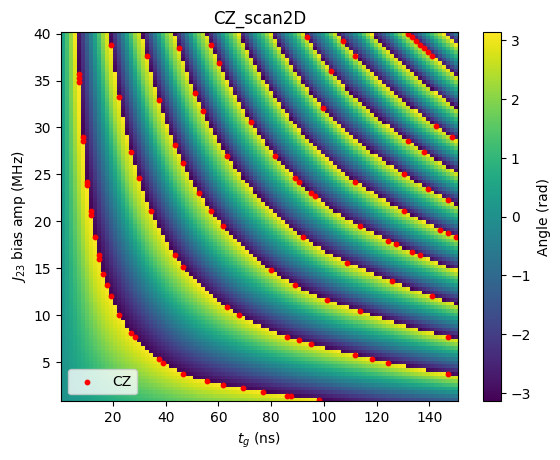

In [24]:
j23_list, tw_list = np.meshgrid( j23bias_scan_rng*1e3, t_width_scan_rng)

tolerance = 0.03  # Define closeness in terms of radians
close_to_neg_pi = np.abs(np.array(angle_cphase) + np.pi) < tolerance
close_to_pi = np.abs(np.array(angle_cphase) - np.pi) < tolerance
%matplotlib inline

plt.figure()
# plt.plot(t_width_scan_rng[min_index[1]],j23bias_scan_rng[min_index[0]]*1e3, '*', color='r')
plt.pcolormesh(tw_list, j23_list,angle_cphase, shading='auto')
plt.colorbar(label='Angle (rad)')
plt.xlabel(r'$t_g$ (ns)')
plt.ylabel(r'$J_{23}$ bias amp (MHz)')

plt.scatter(tw_list[close_to_neg_pi], j23_list[close_to_neg_pi], color='red', s=10, label='CZ')
plt.scatter(tw_list[close_to_pi], j23_list[close_to_pi], color='red', s=10)
plt.legend()
plt.title("CZ_scan2D")

plt.show()

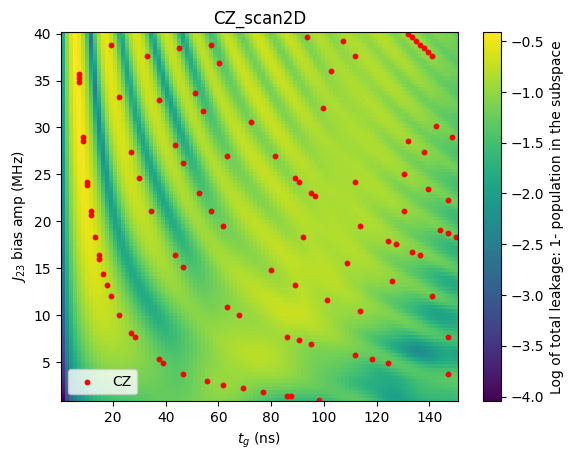

In [25]:
j23_list, tw_list = np.meshgrid( j23bias_scan_rng*1e3, t_width_scan_rng)

plt.figure()
plt.pcolormesh(tw_list, j23_list, np.log10(leakage_list), cmap='viridis')
plt.colorbar(label='Log of total leakage: 1- population in the subspace')
plt.xlabel(r'$t_g$ (ns)')
plt.ylabel(r'$J_{23}$ bias amp (MHz)')

plt.scatter(tw_list[close_to_neg_pi], j23_list[close_to_neg_pi], color='red', s=10, label='CZ')
plt.scatter(tw_list[close_to_pi], j23_list[close_to_pi], color='red', s=10)
plt.legend()
plt.title("CZ_scan2D")

plt.show()

In [27]:
def find_small_indices(A, B):
    # Step 1: Calculate the global threshold (25th percentile)
    threshold_A = np.percentile(A, 13)
    threshold_B = np.percentile(B, 13)
    
    # Step 2: Initialize a result list to store the indices
    result_indices = []
    
    # Step 3: Iterate over each element in the arrays
    for ii in range(A.shape[0]):
        for jj in range(A.shape[1]):
            # Check global condition
            if A[ii][jj] > threshold_A or B[ii][jj] > threshold_B:
                continue
            
            # Check local condition around (ii, jj)
            local_max_A = A[ii][jj]
            local_max_B = B[ii][jj]
            for di in [-1, 0, 1]:
                for dj in [-1, 0, 1]:
                    if 0 <= ii + di < A.shape[0] and 0 <= jj + dj < A.shape[1]:
                        local_max_A = max(local_max_A, A[ii + di][jj + dj])
                        local_max_B = max(local_max_B, B[ii + di][jj + dj])
            
            # Compare local max to current value
            if A[ii][jj] < local_max_A and B[ii][jj] < local_max_B:
                result_indices.append([ii, jj])
    
    return result_indices

In [28]:
find_small_indices(np.array(angle_cphase), np.log10(leakage_list))

[[9, 45], [9, 46], [9, 47], [86, 57]]

In [20]:
j23bias_scan_rng[9]*1e3

4.545454545454545

In [22]:
t_width_scan_rng[43]

65.71717171717171

In [29]:
angle_cphase[86][57]

-2.3853018375121198

C:\Users\Nichol14\AppData\Local\Temp\ipykernel_18988\3457094179.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(tw_list, j23_list, np.log10(leakage_to_0011), cmap='viridis')


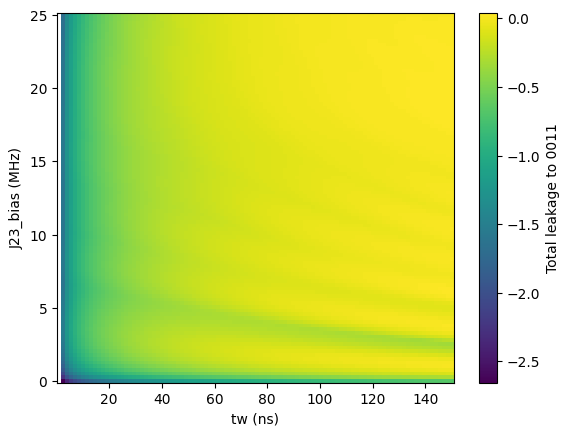

In [ ]:
tw_list, j23_list = np.meshgrid(t_width_scan_rng, j23bias_scan_rng*1e3)

plt.figure()
plt.pcolormesh(tw_list, j23_list, np.log10(leakage_to_0011), cmap='viridis')
plt.colorbar(label='Total leakage to 0011')
plt.xlabel('tw (ns)')
plt.ylabel('J23_bias (MHz)')
plt.show()

C:\Users\Nichol14\AppData\Local\Temp\ipykernel_18988\418111155.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(tw_list, j23_list, np.log10(leakage_to_1100), cmap='viridis')


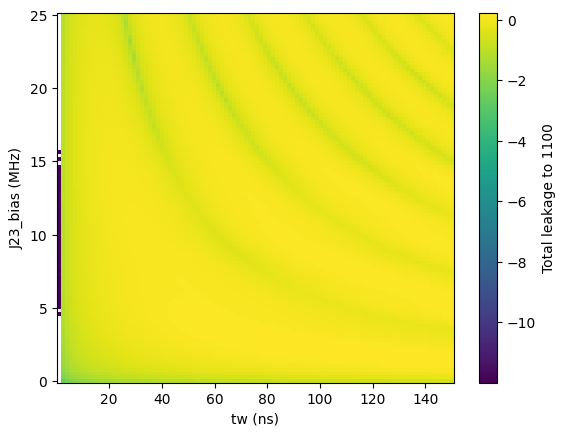

In [ ]:
plt.figure()
plt.pcolormesh(tw_list, j23_list, np.log10(leakage_to_1100), cmap='viridis')
plt.colorbar(label='Total leakage to 1100')
plt.xlabel('tw (ns)')
plt.ylabel('J23_bias (MHz)')
plt.show()